In [1]:
import pandas as pd
import numpy as np 
import networkx as nx
import pickle

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
PREF = 'rus'

In [4]:
with open('data/' + PREF + '_artists_data.pickle', 'rb') as f:
    artists_data = pickle.load(f)

#### Граф связей между художниками по совместным выставкам

In [5]:
from collections import defaultdict

def make_adj_dict_tech(artists_data):
    tech_dict = defaultdict(list)
    
    tech_translate = {
        'живопись': 'живопись', 'акции': 'акция', 'акция': 'акция', 'графика': 'графика', 'объект': 'арт-объект',
        'видео': 'видео', 'реди': 'реди-мейд', 'фото': 'фотография', 'мультимед': 'мультимедиа-инсталляция',
        'интеракт': 'мультимедиа-инсталляция', 'медиа': 'мультимедиа-инсталляция', 'перфоманс': 'перформанс', 
        'граффити': 'стрит-арт', 'инсталляци': 'инсталляция'
    }
    
    for i, artist in enumerate(artists_data):
        if artist['style'] is not None:
            styles = artist['style'].split(',')
            for style_ in styles:
                style = style_.strip().lower()
                for tech in tech_translate:
                    if tech in style:
                        style = tech_translate[tech]
                        break
                tech_dict[style].append(str(i))
    return tech_dict

In [6]:
def make_adj_matrix(artists_data):
    adj = [[0 for i in range(len(artists_data))] for j in range(len(artists_data))]
    for i in range(len(artists_data)):
        artist_1 = artists_data[i]
        if i % 10 == 0:
            print(i, end=' ')
        if artist_1['collective_exh'] is not None:
            for j in range(i + 1, len(artists_data)):
                artist_2 = artists_data[j]
                if artist_2['collective_exh'] is not None and not adj[i][j]:
                    for exh1 in artist_1['collective_exh']:
                        for exh2 in artist_2['collective_exh']:
                            if 'name' in exh1 and 'name' in exh2 and \
                               (exh1['name'], exh1['city'], exh1['year']) == (exh2['name'], exh2['city'], exh2['year']):
                                adj[i][j] += 1
                                adj[j][i] += 1
    return adj

In [7]:
matrix = make_adj_matrix(artists_data)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 

In [8]:
def make_edge_list(matrix):
    edge_list = ''
    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix)):
            if matrix[i][j] != 0:
                edge_list += '%i %i {"weight":%i}\n' % (i, j, matrix[i][j]) 
    return edge_list.split('\n')

In [9]:
edge_list = make_edge_list(matrix)

In [10]:
n_edges = (np.array(matrix) != 0).sum() // 2
n_vertex = len(matrix)
n_edges, n_vertex

(3490, 660)

In [11]:
def add_attr(graph, artists_data):
    names = dict([(str(i), artist['name']) for i, artist in enumerate(artists_data)])
    pers_cnt = dict([(str(i), len(artist['personal_exh'])) 
                          for i, artist in enumerate(artists_data)])
    col_cnt = dict([(str(i), len(artist['collective_exh'])) 
                          for i, artist in enumerate(artists_data)])
    russian_cnt = dict([(str(i), len(list(filter(lambda x: 'country' in x and x['country'] == 'Россия',
                                                 artist['collective_exh'] + artist['personal_exh']))))
                          for i, artist in enumerate(artists_data)])
    nx.set_node_attributes(graph, names, 'name')
    nx.set_node_attributes(graph, col_cnt, 'collective_exh_cnt')
    nx.set_node_attributes(graph, russian_cnt, 'russian_cnt')
   # nx.set_node_attributes(graph, russian_cnt, 'russian_cnt')
    nx.set_node_attributes(graph, pers_cnt, 'personal_exh_cnt')
    return graph

In [12]:
def set_distance(set_1, set_2):
    return len(set_1 & set_2) / len(set_1 | set_2)

def add_tech_weight(tech_dict, graph):
    artists_dict = defaultdict(set)
    for tech in tech_dict:
        for artist in tech_dict[tech]:
            artists_dict[artist].add(tech)
    
    attr = dict()
    for artist_1 in artists_dict:
        for artist_2 in artists_dict:
            dist = set_distance(artists_dict[artist_1], artists_dict[artist_2])
            attr[(artist_1, artist_2)] = dist
    
    nx.set_edge_attributes(graph, attr, "technique_dist")
    return graph

In [13]:
graph = nx.parse_edgelist(edge_list)
graph = add_attr(graph, artists_data)
tech_dict = make_adj_dict_tech(artists_data)
graph = add_tech_weight(tech_dict, graph)

In [14]:
path = 'gexf/' + PREF + '_person_graph.gexf'
nx.write_gexf(graph, path)

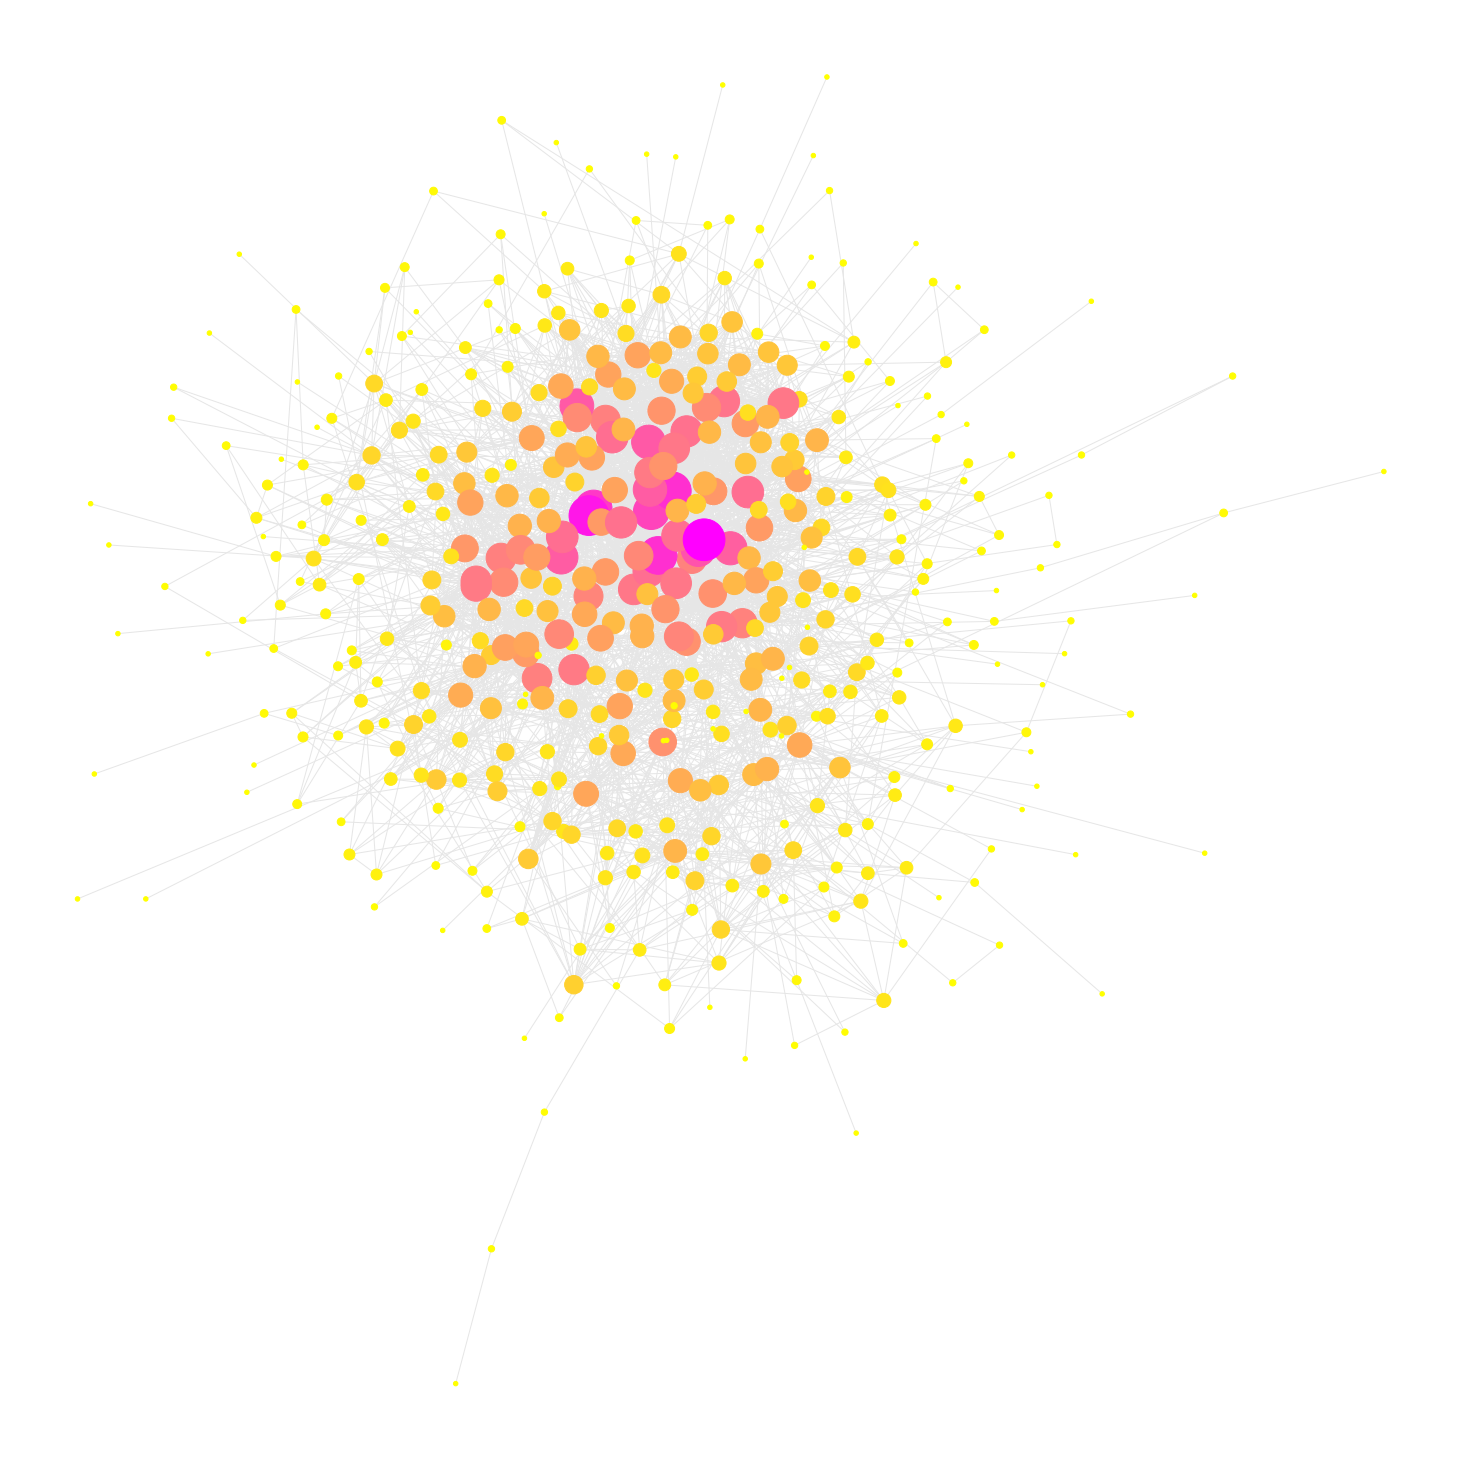

In [15]:
ls = np.linspace(0, 1, 70)
edge_w = [str(ls[graph.edges[edge]['weight']]) for edge in graph.edges]
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
#pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size=[len(graph[v]) * 20 for v in graph], with_labels=False, 
        node_color=[-len(graph[v]) for v in graph], cmap=plt.cm.spring, 
        edge_color='0.9')

#### Граф связей между техниками и художниками

In [16]:
def make_adj_list_tech(tech_dict, treshold=7):
    adj_list = ''
    for tech in tech_dict:
        if len(tech_dict[tech]) >= treshold:
            adj_list += ' '.join([tech.replace(' ', '_')] + tech_dict[tech]) + '\n'
    return adj_list.split('\n')

In [17]:
adj_list = make_adj_list_tech(tech_dict, treshold=8)

In [18]:
graph = nx.parse_adjlist(adj_list)
graph = add_attr(graph, artists_data)

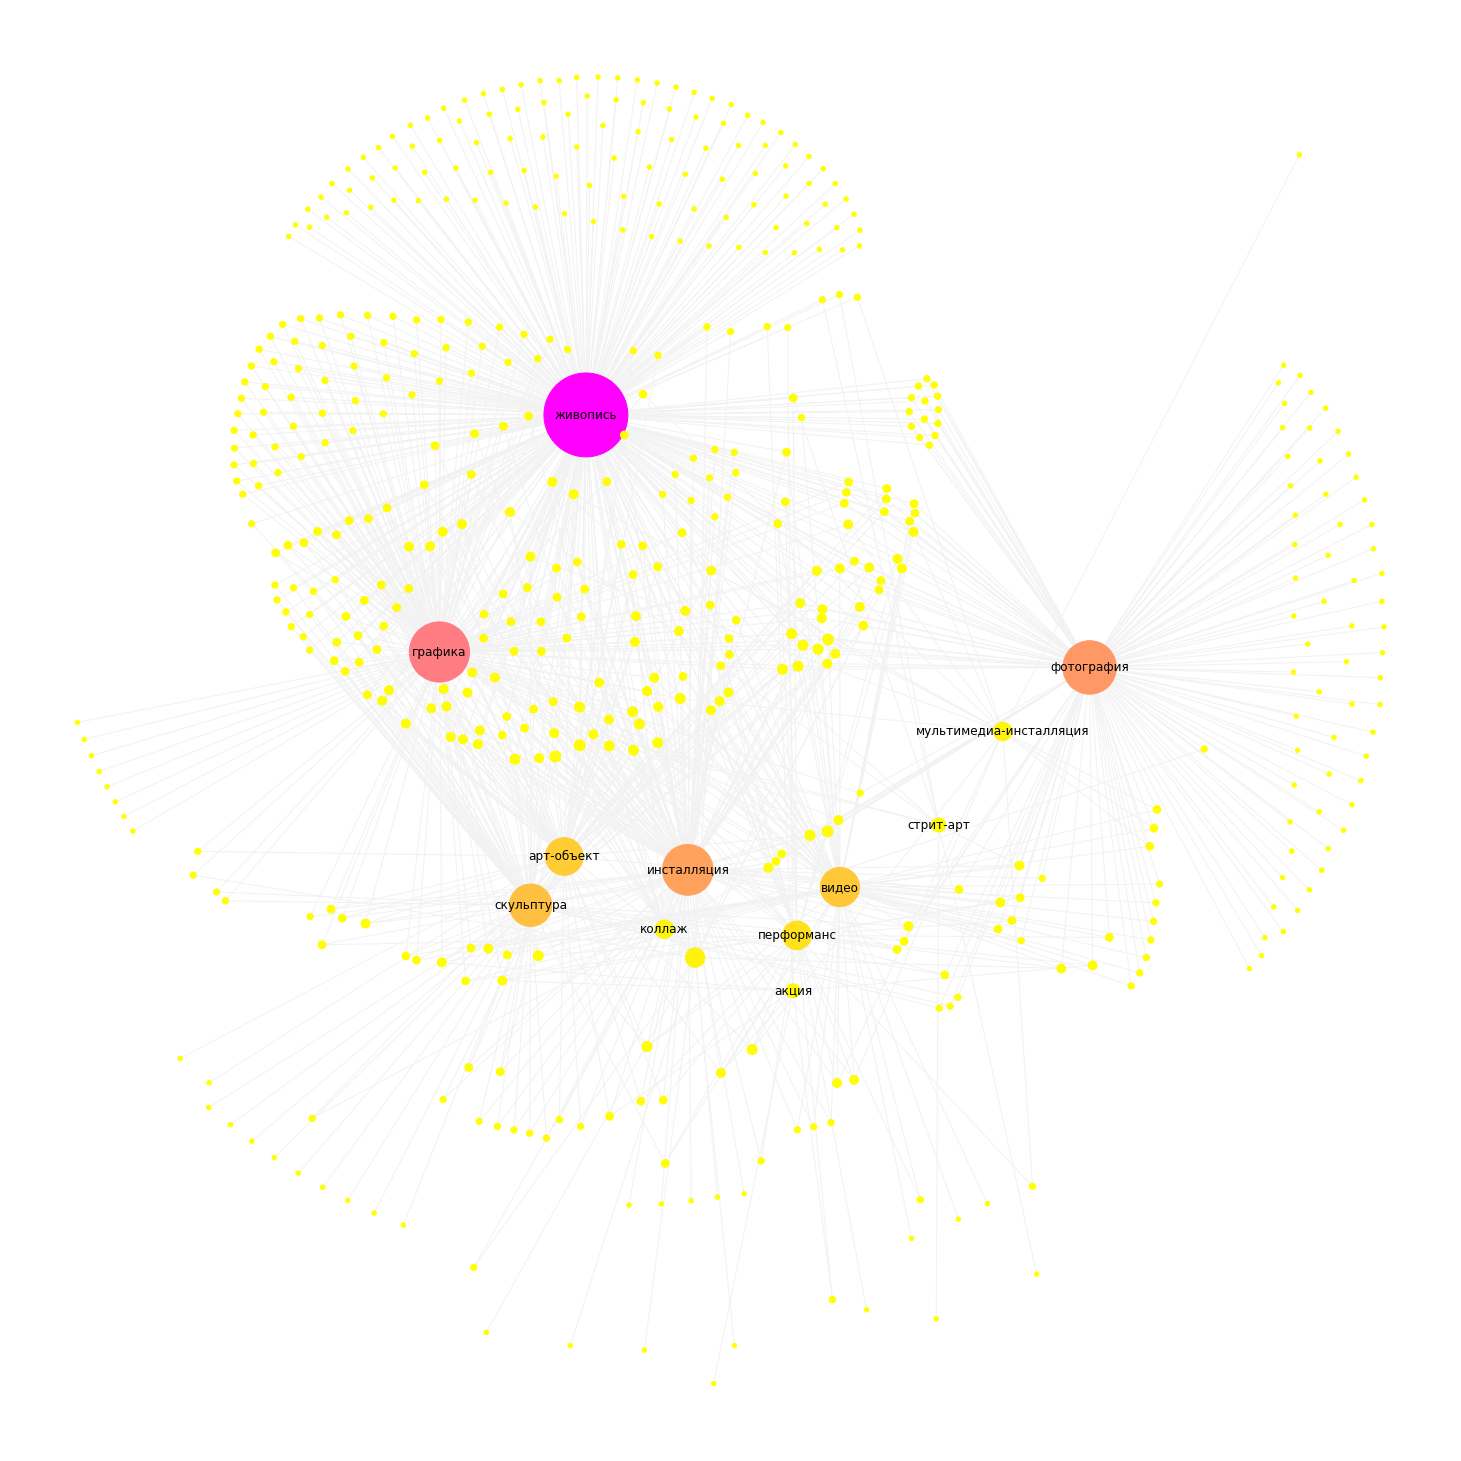

In [19]:
ls = np.linspace(0, 1, 65)
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=[len(graph[v]) * 20 for v in graph], with_labels=False, 
        node_color=[-len(graph[v]) / 2 for v in graph], cmap=plt.cm.spring, 
        edge_color='0.95')
label = nx.draw_networkx_labels(graph, pos, dict([(key, key if key in tech_dict else '') for key in graph.nodes]))
fig.savefig('pdf/graphs/tech_graph_with_artists.pdf')

In [20]:
path = 'gexf/tech_graph.gexf'
nx.write_gexf(graph, path)

#### Граф связей между техниками без художников

In [21]:
def make_edge_list_tech_without_artists(tech_dict, treshold=7):
    adj_list = ''
    for tech in tech_dict:
        if len(tech_dict[tech]) >= treshold and tech != '':
            for tech2 in tech_dict:
                if len(tech_dict[tech2]) >= treshold and tech2 != '':
                    weight = len(set(tech_dict[tech]) & set(tech_dict[tech2]))
                    if weight != 0:
                        adj_list += '%s %s {"weight": %i}\n' % (tech.replace(' ', '_'), tech2.replace(' ', '_'), weight)
    return adj_list.split('\n')

In [22]:
def add_tech_name(graph, tech_dict):
    names = dict([(tech, tech) for tech in tech_dict])
    nx.set_node_attributes(graph, names, 'name')

In [91]:
edge_list = make_edge_list_tech_without_artists(tech_dict)

In [92]:
graph = nx.parse_edgelist(edge_list)
path = 'tech_graph_without_artists'
nx.write_gexf(graph, 'gexf/' + PREF + path + '.gexf')

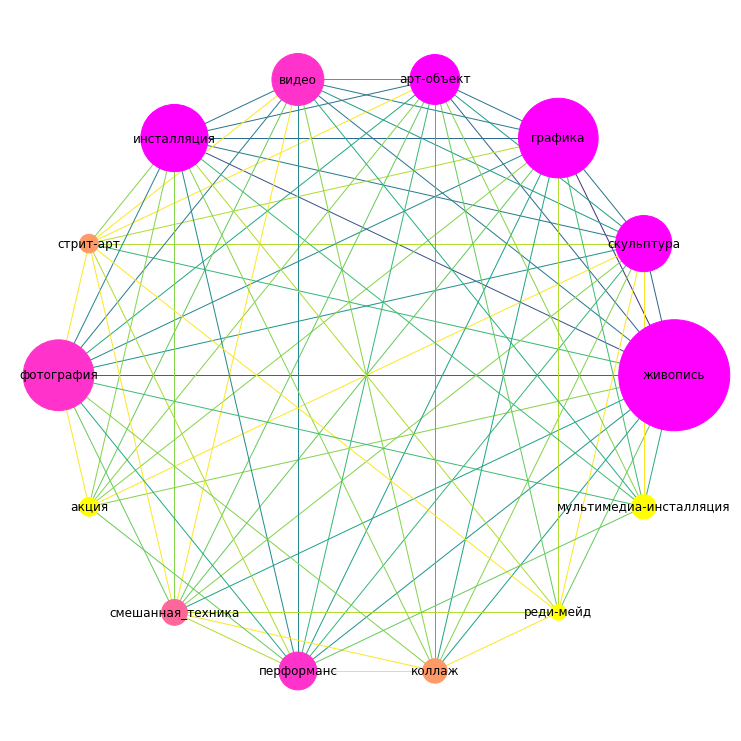

In [103]:
ls = np.linspace(0, 1, 65)
fig = plt.figure(figsize=(10, 10))
pos = nx.shell_layout(graph)
pos = dict([(key, pos[key] * np.array([1, 0.3])) for key in pos])
pos['смешанная_техника'], pos['фотография'] = pos['фотография'], pos['смешанная_техника']
edge_sizes = [-np.log(graph.edges[edge]['weight']) for edge in graph.edges]
node_size = [graph.edges[(v, v)]['weight'] * 35 for v in graph]
nx.draw(graph, pos, node_size=node_size, with_labels=True, 
        node_color=[-len(graph[v]) / 2 for v in graph], cmap=plt.cm.spring, 
        edge_color=edge_sizes, edge_size=1000, font_size=12)
fig.savefig('pdf/graphs/' + path + '.pdf')

#### Связи между художниками и пространствами

In [56]:
gallery_translate = {
    'art play': 'artplay', 'garage': "музей современного искусства гараж", "музей москв": "музей москвы", "гараж":  "музей современного искусства гараж",
    'guelman': "галерея марата гельмана", 'центральный дом художника': 'центральный дом художника', "триумф": "галерея триумф",
    'art&science': 'laboratory art & science', 'цом художника': 'центральный дом художника', 'царицыно': 'царицыно',
    'mmoma': 'московский музей современного искусства', "ммси": 'московский музей современного искусства',
    'московский музей современного искусства': 'московский музей современного искусства', 'арт музей': 'мультимедиа арт музей',
    'moscow museum of modern art': 'московский музей современного искусства', "цдх": "центральный дом художника",
    'pecherskiy gallery': 'pechersky gallery', 'pop/off/art галерея': 'pop/off/art',
    'regina': 'галерея риджина', 'stella art': 'stella art foundation', 'зверев': 'зверевский центр',
    'tv галерея': 'tv галерея', 'vladey': 'vladey space', 'xl gallery': 'xl-галерея', 'галерея xl': 'xl-галерея',
    'артру': 'агентство арт.ru', 'artru': 'агентство арт.ru', 'art ru': 'агентство арт.ru',
    'айдан': 'айдан галерея', 
    'манеж': 'манеж', 'академия художеств': 'академия художеств', 'армянский': 'армянский 13',
    'стрелка': 'арт-стрелка', 'артплей': 'artplay', 'архитектурный музей': 'архитектурный музей им. щусева',
    'щусева': 'архитектурный музей им. щусева', 'artplay': 'artplay', 'триумф': "галерея триумф",
    'третьяков': 'третьяковская галлерея', 'вднх': 'вднх', 'выставка достижений народного хозяйства': 'вднх',
    'каширк': 'выставочный зал каширка', 'гельман': "галерея марата гельмана", "м'арс": "галерея м'арс", 
    "марс": "галерея м'арс", 'сарт': 'галерея с-арт', "m'арс": "галерея м'арс",
    "музей изобразительных искусств имени а. с. пушкина": 'государственный музей изобразительного искусства им. а.с. пушкина', 
    'музей частных коллекций': 'государственный музей изобразительного искусства им. а.с. пушкина',
    'государственный музей а.с. пушкина': 'государственный музей изобразительного искусства им. а.с. пушкина',
    'музей изобразительных искусств им. пушкина': 'государственный музей изобразительного искусства им. а.с. пушкина',
    'государственный музей изобразительных искусств а.с. пушкина': 'государственный музей изобразительного искусства им. а.с. пушкина',
    'росизо': 'росизо', 'центр современного искусства': 'государственный центр современного искусства',
    'дарвинский': 'дарвиновский музей', 'дворец молодёжи': 'дворец молодежи', 'гмии': 'государственный музей изобразительного искусства им. а.с. пушкина',
    'екатерина': 'культурный фонд екатерина', 'грузинская': 'малая грузинская 28', 'литературный музей': 'литературный музей',
}

In [63]:
def make_gallery_dict(artists_data, gallery_translate, city='Москва'):
    galleries = defaultdict(set)
    weights = defaultdict(int)
    for i, artist in enumerate(artists_data):
        exhs = artist['personal_exh'] + artist['collective_exh']
        for exh in exhs:
            if 'city' in exh and exh['city'] == city and 'museum' in exh and exh['museum'] != '':
                museum = exh['museum'].lower()
                if museum == 'дом художника':
                    museum = 'центральный дом художника'
                for m in gallery_translate:
                    if m in museum:
                        museum = gallery_translate[m]
                        break
                museum = museum.strip(' .').replace(' ', '_')
                galleries[museum].add(artist['name'].replace(' ', '_'))
                weights[(museum, artist['name'].replace(' ', '_'))] += 1
    return dict([(str(key), list(map(str, galleries[key])) if key != 'галерея' else []) for key in galleries]), weights

In [64]:
galleries, weights = make_gallery_dict(artists_data, gallery_translate)

In [71]:
top = list(reversed(sorted([(len(galleries[key]), key) for key in galleries])))[:11]
top = [(x[1].replace('_', ' '), x[0]) for x in top]

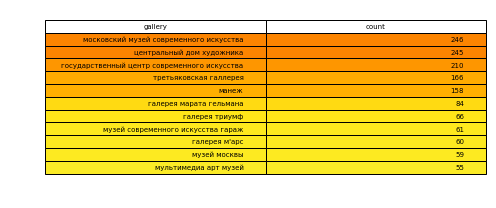

In [86]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.axis('off')
ax.axis('tight')
cm = plt.cm.Wistia
table = pd.DataFrame(top, columns=['gallery', 'count'])
ax.table(cellText=table.values, cellColours=[[cm(x[1]), cm(x[1])] for x in top],
         colLabels=table.columns, loc='center')

fig.tight_layout()
plt.show()
fig.savefig('pdf/tables/gallery_table.pdf')

In [78]:
with open('data/galleries.pickle', 'wb') as f:
    pickle.dump(galleries, f)

In [79]:
#top_galleries = list(reversed(sorted([(len(galleries[key]), key) for key in galleries])))
top_galleries = {
    'московский музей современного искусства': 'ммси',
    'третьяковская галлерея': "третьяковка",
    'манеж': "манеж",
    'центр современного искусства «винзавод»': "винзавод",
    'государственный центр современного искусства': "гцси",
    'галерея марата гельмана': "галерея гельмана",
    'центральный дом художника': "цдх",
    'artplay': 'artplay',
    "галерея м'арс": "м'арс",
    'музей современного искусства гараж': "гараж",
    'галерея триумф': "триумф",
    'музей москвы': "музей москвы",
    'мультимедиа арт музей': "мамм",
    'государственный музей изобразительного искусства им. а.с. пушкина': "гмии им. пушкина",
    'зверевский центр': 'зверевский центр' 
}

In [80]:
adj_list = make_adj_list_tech(galleries, treshold=55)

In [81]:
graph = nx.parse_adjlist(adj_list)
graph = add_attr(graph, artists_data)
names = dict([(key, top_galleries[key.replace('_', ' ')]) if key.replace('_', ' ') in top_galleries else (key, '')
      for key in graph.nodes])

In [82]:
nx.set_edge_attributes(graph, weights, 'weight')
nx.set_node_attributes(graph, names, 'name')
path = 'gallery_graph'
nx.write_gexf(graph, 'gexf/world_' + path + '.gexf')

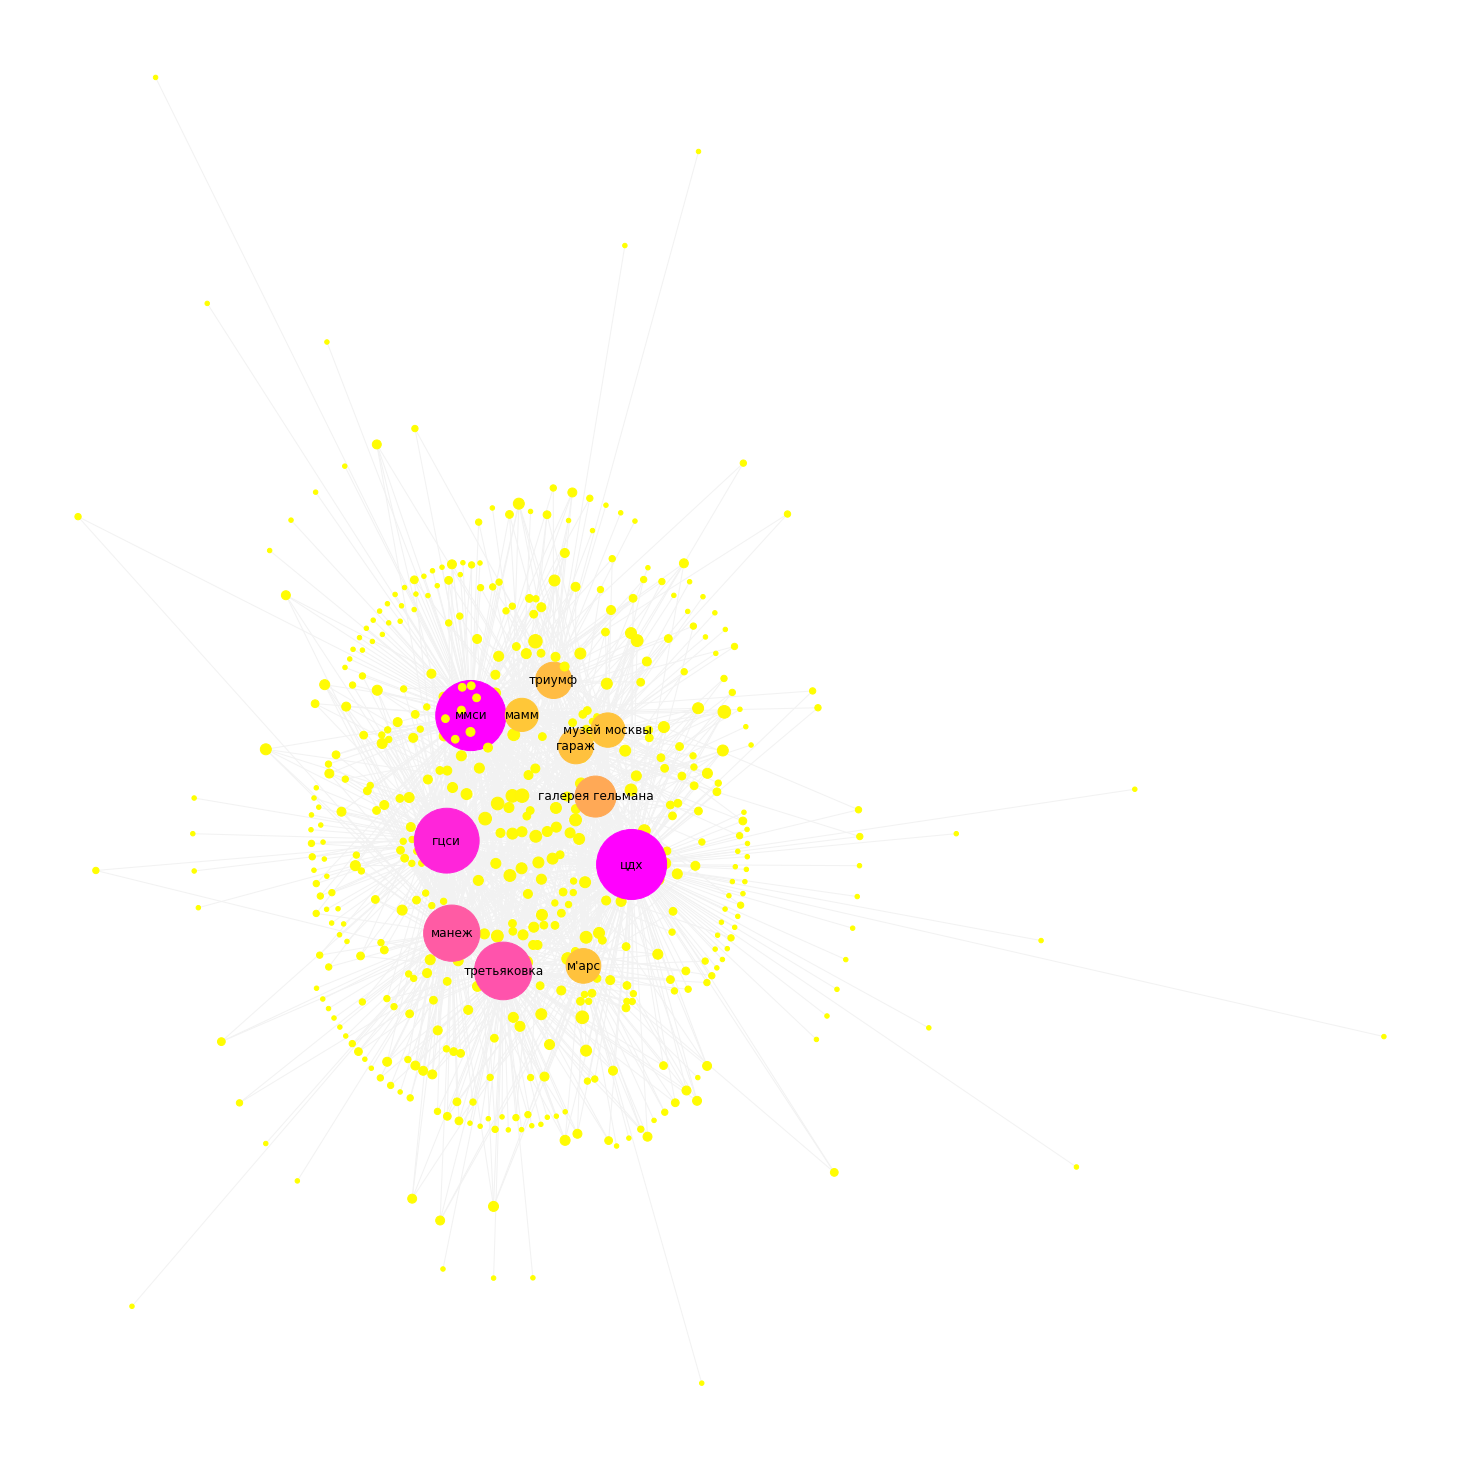

In [83]:
#graph = nx.read_gexf('gexf/' + path + '.gexf')
ls = np.linspace(0, 1, 65)
fig = plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=[len(graph[v]) * 20 for v in graph], with_labels=False, 
        node_color=[-len(graph[v]) / 2 for v in graph], cmap=plt.cm.spring, 
        edge_color='0.95')
label = nx.draw_networkx_labels(graph, pos, names)
fig.savefig('pdf/graphs/world_' + path + '.pdf')

#### Музеи между собой

In [87]:
edge_list = make_edge_list_tech_without_artists(galleries, treshold=55)

In [88]:
graph = nx.parse_edgelist(edge_list)
path = 'galleries_graph_without_artists'
nx.write_gexf(graph, 'gexf/' + path + '.gexf')

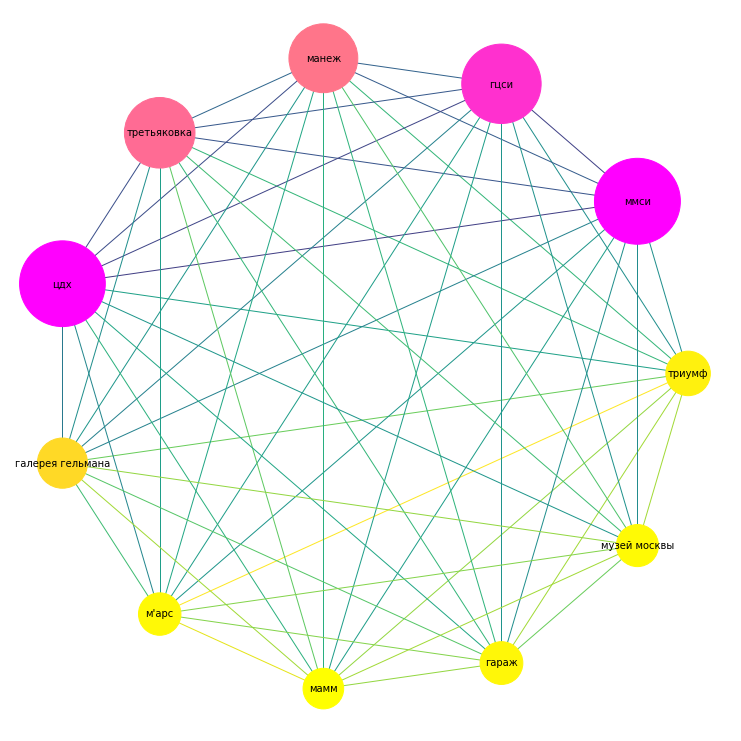

In [89]:
ls = np.linspace(0, 1, 65)
fig = plt.figure(figsize=(10, 10))
pos = nx.shell_layout(graph)
edge_sizes = [-np.log(graph.edges[edge]['weight']) for edge in graph.edges]
node_size = [graph.edges[(v, v)]['weight'] * 30 for v in graph.nodes]
node_color = [-graph.edges[(v, v)]['weight'] * 30 for v in graph.nodes]

nx.draw(graph, pos, node_size=node_size, with_labels=False, 
        node_color=node_color, cmap=plt.cm.spring, 
        edge_color=edge_sizes, edge_size=1000, text_size=0.3)
label = nx.draw_networkx_labels(graph, pos, 
                                dict([(key, top_galleries[key.replace('_', ' ')] if key.replace('_', ' ') in top_galleries else '') 
                                      for key in graph.nodes]),
                                font_size=10
                               )
fig.savefig('pdf/graphs/' + path + '.pdf')